## Goal of this notebook: 
- Find out for which glaciers the runaway effect occurs and if this only occurs for tidewater glaciers!!!

In [22]:
# import some packages that we need later
import xarray as xr
import numpy as np
import pandas as pd
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import dask
import oggm
import geopandas as gpd

### where are most non-land-terminating glaciers
rgi_regs = []
for rgi_reg in np.arange(1,20,1):
    if rgi_reg < 10:
        rgi_reg = '0'+str(rgi_reg)
    else:
        rgi_reg = str(rgi_reg)

    path_rgi = oggm.utils.get_rgi_region_file(rgi_reg, version='6')
    rgidf_t = gpd.read_file(path_rgi)
    print(f'RGI region: {rgi_reg}')
    print(len(rgidf_t.loc[rgidf_t['TermType']!=0]))

RGI region: 01
199
RGI region: 02
0
RGI region: 03
258
RGI region: 04
68
RGI region: 05
903
RGI region: 06
0
RGI region: 07
141
RGI region: 08
0
RGI region: 09
379
RGI region: 10
2
RGI region: 11
0
RGI region: 12
0
RGI region: 13
0
RGI region: 14
0
RGI region: 15
0
RGI region: 16
0
RGI region: 17
218
RGI region: 18
0
RGI region: 19
1521


#### Now let's just focus on one region, ssp & time period!

In [86]:
rgi_reg = '19'
ssp_sel = 'ssp585'
period_sel = 2081
y0_times = [period_sel]

path_rgi = oggm.utils.get_rgi_region_file(rgi_reg, version='6')
rgidf = gpd.read_file(path_rgi)
rgidf.index = rgidf['RGIId'].values

In [87]:
model_author = 'Rounce'
gcms = ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll' ]
scenarios = ['hist', #orical',
             'ssp126', 'ssp370', 'ssp585']
# we mostly saw the runaway effect for warmer temperature scenarios (i.e. in future scenarios...)
#y0_times = [2021, 2041, 2061, 2081]

#y0_times = [2021, 2041] #,
#y0_times = [2021, 2041]

folder_path = '/home/www/drounce/per_glacier/'
#for rgi_reg in [rgi_reg_sel]:
print(f'rgi_reg: {rgi_reg} started')
_l_period = []
for y0_time in y0_times:
    period = f'{y0_time}-{y0_time+19}'
    if y0_time in [1851, 1901, 1951, 1995]:
        scenarios_sel = ['hist']
    else:
        scenarios_sel = scenarios[1:]
    # simpler for the moment
    scenarios_sel = [ssp_sel]
    # just because I have to repeat the 1995 again !!!
    _l_scenario = []
    for scenario in scenarios_sel:
        _l_gcm = []
        for gcm in gcms:
            path = folder_path + f'{rgi_reg}/{model_author}_rgi{rgi_reg}_glaciers_{period}_{gcm}_{scenario}*.nc'
            ds = xr.open_mfdataset(path)
            ds = ds.isel(simulation_year=np.arange(0,ds.simulation_year.values[-1],10))
            ds = ds.load()
            #ds = ds.reset_coords()[['volume_m3', 'area_m2']]
            ds = ds.expand_dims({'gcm':[gcm], 'ssp':[scenario], 'period':[period], 'rgi_reg':[rgi_reg]})
            _l_gcm.append(ds)
        _l_scenario.append(xr.concat(_l_gcm, dim='gcm'))
    _l_period.append(xr.concat(_l_scenario, dim='ssp'))
ds_future = xr.concat(_l_period, dim='period')

rgi_reg: 19 started


### How to identify a glacier with a runaway effect?


In [88]:
ds_future_hot = ds_future #.sel(ssp='ssp585').sel(period='2081-2100').volume_m3.load()
df_itmix = pd.read_hdf(oggm.utils.get_demo_file('rgi62_itmix_df.h5'))
vol_itmix_rgi_reg=df_itmix.loc[ds_future_hot.rgi_id.values]['vol_itmix_m3'].sum()

# it should have a larger end volume than initial volume
condi1 = ds_future_hot.volume_m3.isel(simulation_year=-1) > ds_future_hot.volume_m3.isel(simulation_year=0)
# it should first melt by at least 20% and then "runaway"
condi2 = ds_future_hot.volume_m3.min() < 0.8*ds_future_hot.volume_m3.isel(simulation_year=0)

In [89]:
ds_condi = ds_future_hot.where(condi1 & condi2).volume_m3/vol_itmix_rgi_reg
pd_crazy = ds_condi.isel(simulation_year=-1).to_dataframe()
pd_init = ds_condi.isel(simulation_year=0).to_dataframe()

pd_ratio_final_init = (ds_condi.isel(simulation_year=-1)/ds_condi.isel(simulation_year=0)).to_dataframe()


In [90]:
pd_ratio_final_init = pd_ratio_final_init.rename(columns={'volume_m3':'vol_ratio_final_vs_init'})
pd_crazy = pd_crazy.rename(columns={'volume_m3':'ratio_final_vs_initial_reg_volume'})
pd_init = pd_init.rename(columns={'volume_m3':'ratio_initial_vs_initial_reg_volume'})

In [91]:
pd_runaway = pd.concat([pd_init.drop(columns='simulation_year'), pd_crazy.drop(columns='simulation_year'), pd_ratio_final_init], axis=1)

In [92]:
pd_runaway = pd_runaway.dropna().reset_index()
#pd_runaway = pd_runaway.loc[pd_runaway.gcm == 'mri-esm2-0']
pd_runaway['TermType'] = rgidf.loc[pd_runaway.rgi_id.values]['TermType'].values

In [93]:
pd_runaway.sort_values('ratio_final_vs_initial_reg_volume', ascending=False)[:20]

gcm     ssp     period rgi_reg          rgi_id  \
431   ukesm1-0-ll  ssp585  2081-2100      19  RGI60-19.02147   
176  ipsl-cm6a-lr  ssp585  2081-2100      19  RGI60-19.02147   
369    mri-esm2-0  ssp585  2081-2100      19  RGI60-19.02147   
432   ukesm1-0-ll  ssp585  2081-2100      19  RGI60-19.02149   
177  ipsl-cm6a-lr  ssp585  2081-2100      19  RGI60-19.02149   
370    mri-esm2-0  ssp585  2081-2100      19  RGI60-19.02149   
90      gfdl-esm4  ssp585  2081-2100      19  RGI60-19.02147   
429   ukesm1-0-ll  ssp585  2081-2100      19  RGI60-19.02137   
392   ukesm1-0-ll  ssp585  2081-2100      19  RGI60-19.00133   
174  ipsl-cm6a-lr  ssp585  2081-2100      19  RGI60-19.02137   
141  ipsl-cm6a-lr  ssp585  2081-2100      19  RGI60-19.01521   
366    mri-esm2-0  ssp585  2081-2100      19  RGI60-19.02137   
391   ukesm1-0-ll  ssp585  2081-2100      19  RGI60-19.00130   
405   ukesm1-0-ll  ssp585  2081-2100      19  RGI60-19.01521   
140  ipsl-cm6a-lr  ssp585  2081-2100      19  RGI60-19.01520   
404   ukesm1-0-ll  ssp585  2081-2100      19  RGI60-19.01520   
328    mri-esm2-0  ssp585  2081-2100      19  RGI60-19.01521   
15      gfdl-esm4  ssp585  2081-2100      19  RGI60-19.00115   
303    mri-esm2-0  ssp585  2081-2100      19  RGI60-19.00130   
327    mri-esm2-0  ssp585  2081-2100      19  RGI60-19.01520   

     ratio_initial_vs_initial_reg_volume  ratio_final_vs_initial_reg_volume  \
431                             0.000251                         102.344238   
176                             0.000248                          56.393559   
369                             0.000248                          36.459141   
432                             0.000115                          12.051375   
177                             0.000114                           7.397171   
370                             0.000114                           5.620395   
90                              0.000237                           5.288846   
429                             0.000088                           0.143762   
392                             0.009249                           0.135767   
174                             0.000086                           0.124645   
141                             0.000732                           0.121152   
366                             0.000086                           0.096359   
391                             0.000607                           0.095737   
405                             0.000722                           0.083010   
140                             0.000858                           0.077781   
404                             0.000849                           0.066683   
328                             0.000743                           0.064275   
15                              0.032126                           0.063780   
303                             0.000594                           0.063476   
327                             0.000868                           0.060982   

     vol_ratio_final_vs_init  TermType  
431            408149.437500         1  
176            227805.921875         1  
369            146877.671875         1  
432            104403.710938         1  
177             65005.660156         1  
370             49195.476562         1  
90              22331.208984         1  
429              1632.575073         1  
392                14.679139         5  
174              1442.752686         1  
141               165.597198         1  
366              1120.692749         1  
391               157.628937         5  
405               115.021828         1  
140                90.630600         1  
404                78.510651         1  
328                86.507484         1  
15                  1.985282         5  
303               106.833076         5  
327                70.273834         1

In [94]:
pd_bad_glaciers = pd_runaway.loc[pd_runaway['vol_ratio_final_vs_init']>2].sort_values('ratio_final_vs_initial_reg_volume', ascending=False)
pd_bad_glaciers

gcm     ssp     period rgi_reg          rgi_id  \
431    ukesm1-0-ll  ssp585  2081-2100      19  RGI60-19.02147   
176   ipsl-cm6a-lr  ssp585  2081-2100      19  RGI60-19.02147   
369     mri-esm2-0  ssp585  2081-2100      19  RGI60-19.02147   
432    ukesm1-0-ll  ssp585  2081-2100      19  RGI60-19.02149   
177   ipsl-cm6a-lr  ssp585  2081-2100      19  RGI60-19.02149   
..             ...     ...        ...     ...             ...   
69       gfdl-esm4  ssp585  2081-2100      19  RGI60-19.01893   
57       gfdl-esm4  ssp585  2081-2100      19  RGI60-19.01815   
368     mri-esm2-0  ssp585  2081-2100      19  RGI60-19.02145   
55       gfdl-esm4  ssp585  2081-2100      19  RGI60-19.01797   
274  mpi-esm1-2-hr  ssp585  2081-2100      19  RGI60-19.02140   

     ratio_initial_vs_initial_reg_volume  ratio_final_vs_initial_reg_volume  \
431                         2.507519e-04                         102.344238   
176                         2.475509e-04                          56.393559   
369                         2.482279e-04                          36.459141   
432                         1.154305e-04                          12.051375   
177                         1.137927e-04                           7.397171   
..                                   ...                                ...   
69                          1.336880e-05                           0.000028   
57                          4.931858e-06                           0.000027   
368                         8.350377e-07                           0.000022   
55                          5.330722e-06                           0.000012   
274                         1.178724e-06                           0.000007   

     vol_ratio_final_vs_init  TermType  
431            408149.437500         1  
176            227805.921875         1  
369            146877.671875         1  
432            104403.710938         1  
177             65005.660156         1  
..                       ...       ...  
69                  2.095277         1  
57                  5.479810         1  
368                26.296656         1  
55                  2.341202         1  
274                 5.924628         1  

[369 rows x 9 columns]

In [95]:
bad_glaciers = pd_bad_glaciers.rgi_id.unique()
len(bad_glaciers)

138

In [96]:
very_bad_glaciers = pd_bad_glaciers[pd_bad_glaciers['vol_ratio_final_vs_init']>40].rgi_id.unique()
# the very bad glaciers are all marine-terminating !!!
assert np.all(pd_bad_glaciers[pd_bad_glaciers['vol_ratio_final_vs_init']>40]['TermType'] !=0)
len(very_bad_glaciers)

50

In [97]:
# bad glaciers correspond at beginning to around ...% of initial RGI volume:
100*(ds_future_hot.sel(rgi_id=bad_glaciers).isel(simulation_year=0).sum(dim='rgi_id')/vol_itmix_rgi_reg).volume_m3.mean()

<xarray.DataArray 'volume_m3' ()>
array(6.62754029)
Coordinates:
    simulation_year  int16 0

In [98]:
# very bad glaciers correspond at beginning to around ... of initial RGI volume:
100*(ds_future_hot.sel(rgi_id=very_bad_glaciers).isel(simulation_year=0).sum(dim='rgi_id')/vol_itmix_rgi_reg).volume_m3.mean()

<xarray.DataArray 'volume_m3' ()>
array(0.63734101)
Coordinates:
    simulation_year  int16 0

In [99]:
# checkout the range of the entire runaway effect:
(ds_future_hot.isel(simulation_year=-1).sum(dim='rgi_id')/vol_itmix_rgi_reg).volume_m3.to_dataframe()

simulation_year   volume_m3
gcm           ssp    period    rgi_reg                             
gfdl-esm4     ssp585 2081-2100 19                  4990    5.690691
ipsl-cm6a-lr  ssp585 2081-2100 19                  4990   64.617065
mpi-esm1-2-hr ssp585 2081-2100 19                  4990    0.388654
mri-esm2-0    ssp585 2081-2100 19                  4990   42.889088
ukesm1-0-ll   ssp585 2081-2100 19                  4990  115.389908

In [100]:
# now only look at the bad glaciers (for RGI01: 17 glac): we see that they are responsible for most of the runaway effect of initial RGI volume:
(ds_future_hot.sel(rgi_id=bad_glaciers).isel(simulation_year=-1).sum(dim='rgi_id')/vol_itmix_rgi_reg).volume_m3.to_dataframe()

simulation_year   volume_m3
gcm           ssp    period    rgi_reg                             
gfdl-esm4     ssp585 2081-2100 19                  4990    5.484838
ipsl-cm6a-lr  ssp585 2081-2100 19                  4990   64.489891
mpi-esm1-2-hr ssp585 2081-2100 19                  4990    0.251242
mri-esm2-0    ssp585 2081-2100 19                  4990   42.740074
ukesm1-0-ll   ssp585 2081-2100 19                  4990  115.235023

In [101]:
# now only look at the very bad glaciers (for RGI01: 5glac): we see that they are responsible for most of the runaway effect of initial RGI01 volume:
(ds_future_hot.sel(rgi_id=very_bad_glaciers).isel(simulation_year=-1).sum(dim='rgi_id')/vol_itmix_rgi_reg).volume_m3.to_dataframe()

simulation_year   volume_m3
gcm           ssp    period    rgi_reg                             
gfdl-esm4     ssp585 2081-2100 19                  4990    5.410159
ipsl-cm6a-lr  ssp585 2081-2100 19                  4990   64.373085
mpi-esm1-2-hr ssp585 2081-2100 19                  4990    0.166727
mri-esm2-0    ssp585 2081-2100 19                  4990   42.608143
ukesm1-0-ll   ssp585 2081-2100 19                  4990  114.891838

In [102]:
# now remove the bad glaciers: we see that they are responsible for most of the runaway effect of initial RGI volume:
(ds_future_hot.drop_sel(rgi_id=bad_glaciers).isel(simulation_year=-1).sum(dim='rgi_id')/vol_itmix_rgi_reg).volume_m3.to_dataframe()

simulation_year  volume_m3
gcm           ssp    period    rgi_reg                            
gfdl-esm4     ssp585 2081-2100 19                  4990   0.205854
ipsl-cm6a-lr  ssp585 2081-2100 19                  4990   0.127185
mpi-esm1-2-hr ssp585 2081-2100 19                  4990   0.137411
mri-esm2-0    ssp585 2081-2100 19                  4990   0.149011
ukesm1-0-ll   ssp585 2081-2100 19                  4990   0.154853

In [103]:
plt.rcParams.update( {'font.size':20})

very crazy non-land-terminating glaciers:
['RGI60-19.02147' 'RGI60-19.02149' 'RGI60-19.02137' 'RGI60-19.01521'
 'RGI60-19.00130' 'RGI60-19.01520' 'RGI60-19.02134' 'RGI60-19.00277'
 'RGI60-19.00128' 'RGI60-19.00205' 'RGI60-19.00132' 'RGI60-19.00345'
 'RGI60-19.00238' 'RGI60-19.00257' 'RGI60-19.00003' 'RGI60-19.00023'
 'RGI60-19.00039' 'RGI60-19.00193' 'RGI60-19.00315' 'RGI60-19.01885'
 'RGI60-19.01891' 'RGI60-19.00106' 'RGI60-19.00033' 'RGI60-19.01837'
 'RGI60-19.00165' 'RGI60-19.00030' 'RGI60-19.00261' 'RGI60-19.01847'
 'RGI60-19.00038' 'RGI60-19.00221' 'RGI60-19.01890' 'RGI60-19.01049'
 'RGI60-19.01981' 'RGI60-19.02123' 'RGI60-19.01880' 'RGI60-19.01879'
 'RGI60-19.01893' 'RGI60-19.00227' 'RGI60-19.02111' 'RGI60-19.01883'
 'RGI60-19.02122' 'RGI60-19.02165' 'RGI60-19.01895' 'RGI60-19.01788'
 'RGI60-19.02130' 'RGI60-19.02113' 'RGI60-19.00188' 'RGI60-19.02114'
 'RGI60-19.01782' 'RGI60-19.02145']


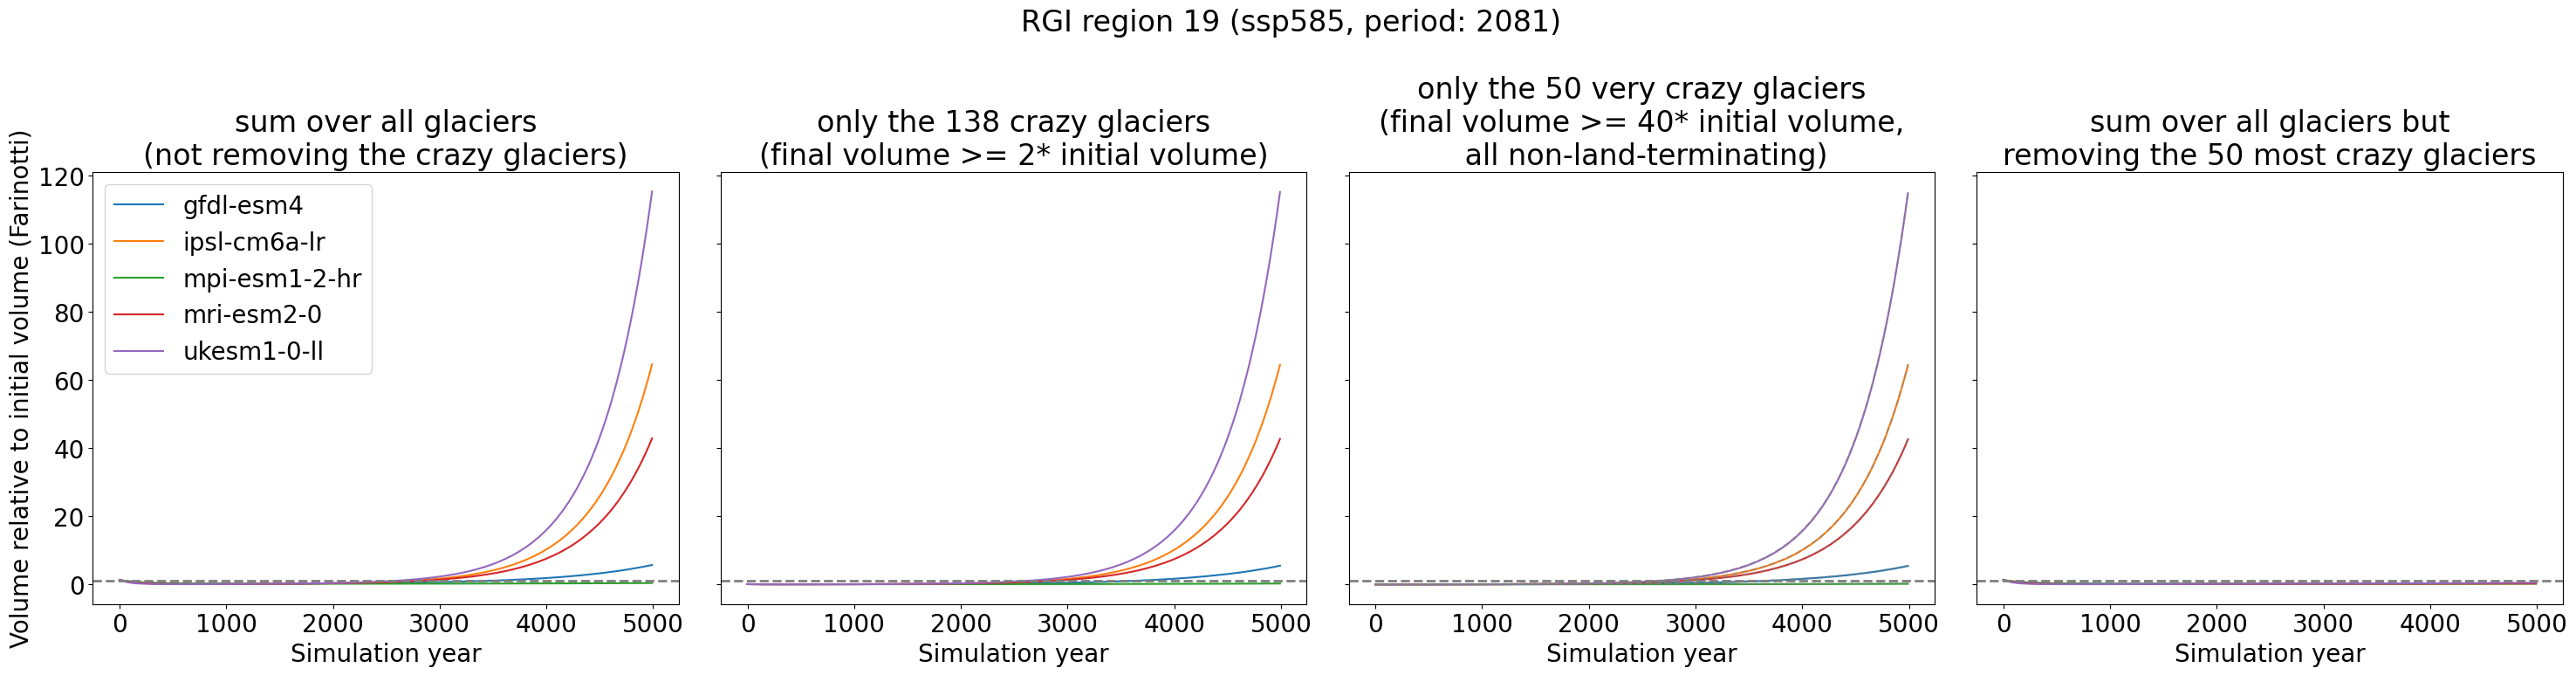

In [104]:
fig, axs = plt.subplots(1,4, figsize=(30, 8), sharey=True)
ax = axs[0]
plt.suptitle(f'RGI region {rgi_reg} ({ssp_sel}, period: {period_sel})')
#plt.suptitle(f'RGI region {rgi_reg} (ssp585, period: 2081-2100)')
ax.set_title('sum over all glaciers\n(not removing the crazy glaciers)')
for gcm in gcms:
    ax.plot(ds_future_hot.simulation_year, (ds_future_hot.sel(gcm=gcm).volume_m3.sum(dim='rgi_id')/vol_itmix_rgi_reg).values.flatten(),
            label=gcm)
ax.set_ylabel('Volume relative to initial volume (Farinotti)')
ax.set_xlabel('Simulation year')
ax.legend()
ax.axhline(1, color = 'grey', ls='--', lw=2)

ax = axs[1]
ax.set_title(f'only the {len(bad_glaciers)} crazy glaciers\n(final volume >= 2* initial volume)')
for gcm in gcms:
    ax.plot(ds_future_hot.simulation_year, (ds_future_hot.sel(rgi_id=bad_glaciers).sel(gcm=gcm).volume_m3.sum(dim='rgi_id')/vol_itmix_rgi_reg).values.flatten(),
            label=gcm)
#ax.set_ylabel('Volume relative to initial volume (Farinotti)')
ax.set_xlabel('Simulation year')
#ax.legend()
ax.axhline(1, color = 'grey', ls='--', lw=2)

ax = axs[2]
ax.set_title(f'only the {len(very_bad_glaciers)} very crazy glaciers\n(final volume >= 40* initial volume,\n all non-land-terminating)')
for gcm in gcms:
    ax.plot(ds_future_hot.simulation_year, (ds_future_hot.sel(rgi_id=very_bad_glaciers).sel(gcm=gcm).volume_m3.sum(dim='rgi_id')/vol_itmix_rgi_reg).values.flatten(),
            label=gcm)
#ax.set_ylabel('Volume relative to initial volume (Farinotti)')
ax.set_xlabel('Simulation year')
#ax.legend()

for gcm in gcms:
    ax.plot(ds_future_hot.simulation_year, (ds_future_hot.sel(rgi_id=bad_glaciers).sel(gcm=gcm).volume_m3.sum(dim='rgi_id')/vol_itmix_rgi_reg).values.flatten(),
            label=gcm, ls = '--', color='grey', alpha = 0.5)
ax.axhline(1, color = 'grey', ls='--', lw=2)

ax = axs[3]
if len(very_bad_glaciers) == 0:
    ax.set_title(f'sum over all glaciers but\nremoving the {len(bad_glaciers)} slightly crazy glaciers')
    for gcm in gcms:
        ax.plot(ds_future_hot.simulation_year, (ds_future_hot.drop_sel(rgi_id=bad_glaciers).sel(gcm=gcm).volume_m3.sum(dim='rgi_id')/vol_itmix_rgi_reg).values.flatten(),
                label=gcm)
else:
    ax.set_title(f'sum over all glaciers but\nremoving the {len(very_bad_glaciers)} most crazy glaciers')
    for gcm in gcms:
        ax.plot(ds_future_hot.simulation_year, (ds_future_hot.drop_sel(rgi_id=very_bad_glaciers).sel(gcm=gcm).volume_m3.sum(dim='rgi_id')/vol_itmix_rgi_reg).values.flatten(),
                label=gcm)
#ax.set_ylabel('Volume relative to initial volume (Farinotti)')
ax.set_xlabel('Simulation year')
#ax.legend()
ax.axhline(1, color = 'grey', ls='--', lw=2)
plt.tight_layout()
plt.savefig(f'Rounce_rgireg{rgi_reg}_{ssp_sel}_{period_sel}_runaway_effect_crazy_glaciers.png')
print(f'very crazy non-land-terminating glaciers:\n{very_bad_glaciers}')

In [105]:
fig, axs = plt.subplots(1,4, figsize=(30, 8), sharey=True)
ax = axs[0]
ax.semilogy()
plt.suptitle(f'RGI region {rgi_reg} ({ssp_sel}, period: {period_sel})')
ax.set_title('sum over all glaciers\n(not removing the crazy glaciers)')
for gcm in gcms:
    ax.plot(ds_future_hot.simulation_year, (ds_future_hot.sel(gcm=gcm).volume_m3.sum(dim='rgi_id')/vol_itmix_rgi_reg).values.flatten(),
            label=gcm)
ax.set_ylabel('Volume relative to initial volume (Farinotti)')
ax.set_xlabel('Simulation year')
ax.legend()
ax.axhline(1, color = 'grey', ls='--', lw=2)

ax = axs[1]
ax.semilogy()
ax.set_title(f'only the {len(bad_glaciers)} crazy glaciers\n(final volume >= 2* initial volume)')
for gcm in gcms:
    ax.plot(ds_future_hot.simulation_year, (ds_future_hot.sel(rgi_id=bad_glaciers).sel(gcm=gcm).volume_m3.sum(dim='rgi_id')/vol_itmix_rgi_reg).values.flatten(),
            label=gcm)
#ax.set_ylabel('Volume relative to initial volume (Farinotti)')
ax.set_xlabel('Simulation year')
#ax.legend()
ax.axhline(1, color = 'grey', ls='--', lw=2)

ax = axs[2]
ax.set_title(f'only the {len(very_bad_glaciers)} very crazy glaciers\n(final volume >= 40* initial volume,\n all non-land-terminating)')
for gcm in gcms:
    ax.plot(ds_future_hot.simulation_year, (ds_future_hot.sel(rgi_id=very_bad_glaciers).sel(gcm=gcm).volume_m3.sum(dim='rgi_id')/vol_itmix_rgi_reg).values.flatten(),
            label=gcm)
#ax.set_ylabel('Volume relative to initial volume (Farinotti)')
ax.set_xlabel('Simulation year')
#ax.legend()

for gcm in gcms:
    ax.plot(ds_future_hot.simulation_year, (ds_future_hot.sel(gcm=gcm).volume_m3.sum(dim='rgi_id')/vol_itmix_rgi_reg).values.flatten(),
            label=gcm, ls = '--', color='grey', alpha = 0.8)
ax.text(0.1, 50, 'in grey: sum over all glaciers')

ax.axhline(1, color = 'grey', ls='--', lw=2)
ax = axs[3]
ax.set_title(f'sum over all glaciers but\nremoving the {len(very_bad_glaciers)} most crazy glaciers')

if len(very_bad_glaciers) == 0:
    ax.set_title(f'sum over all glaciers but\nremoving the {len(bad_glaciers)} slightly crazy glaciers')
    for gcm in gcms:
        ax.plot(ds_future_hot.simulation_year, (ds_future_hot.drop_sel(rgi_id=bad_glaciers).sel(gcm=gcm).volume_m3.sum(dim='rgi_id')/vol_itmix_rgi_reg).values.flatten(),
                label=gcm)
else:
    ax.set_title(f'sum over all glaciers but\nremoving the {len(very_bad_glaciers)} most crazy glaciers')
    for gcm in gcms:
        ax.plot(ds_future_hot.simulation_year, (ds_future_hot.drop_sel(rgi_id=very_bad_glaciers).sel(gcm=gcm).volume_m3.sum(dim='rgi_id')/vol_itmix_rgi_reg).values.flatten(),
                label=gcm)

#ax.set_ylabel('Volume relative to initial volume (Farinotti)')
ax.set_xlabel('Simulation year')
#ax.legend()
ax.axhline(1, color = 'grey', ls='--', lw=2)
plt.tight_layout()
plt.savefig(f'Rounce_rgireg{rgi_reg}_{ssp_sel}_{period_sel}_runaway_effect_crazy_glaciers_log.png')
#plt.savefig(f'Rounce_rgireg{rgi_reg}_ssp585_2081_2100_runaway_effect_crazy_glaciers_log.png')
print(f'very crazy non-land-terminating glaciers:\n{very_bad_glaciers}')

very crazy non-land-terminating glaciers:
['RGI60-19.02147' 'RGI60-19.02149' 'RGI60-19.02137' 'RGI60-19.01521'
 'RGI60-19.00130' 'RGI60-19.01520' 'RGI60-19.02134' 'RGI60-19.00277'
 'RGI60-19.00128' 'RGI60-19.00205' 'RGI60-19.00132' 'RGI60-19.00345'
 'RGI60-19.00238' 'RGI60-19.00257' 'RGI60-19.00003' 'RGI60-19.00023'
 'RGI60-19.00039' 'RGI60-19.00193' 'RGI60-19.00315' 'RGI60-19.01885'
 'RGI60-19.01891' 'RGI60-19.00106' 'RGI60-19.00033' 'RGI60-19.01837'
 'RGI60-19.00165' 'RGI60-19.00030' 'RGI60-19.00261' 'RGI60-19.01847'
 'RGI60-19.00038' 'RGI60-19.00221' 'RGI60-19.01890' 'RGI60-19.01049'
 'RGI60-19.01981' 'RGI60-19.02123' 'RGI60-19.01880' 'RGI60-19.01879'
 'RGI60-19.01893' 'RGI60-19.00227' 'RGI60-19.02111' 'RGI60-19.01883'
 'RGI60-19.02122' 'RGI60-19.02165' 'RGI60-19.01895' 'RGI60-19.01788'
 'RGI60-19.02130' 'RGI60-19.02113' 'RGI60-19.00188' 'RGI60-19.02114'
 'RGI60-19.01782' 'RGI60-19.02145']


gfdl-esm4
['ssp585']
['2081-2100']
RGI60-19.02149


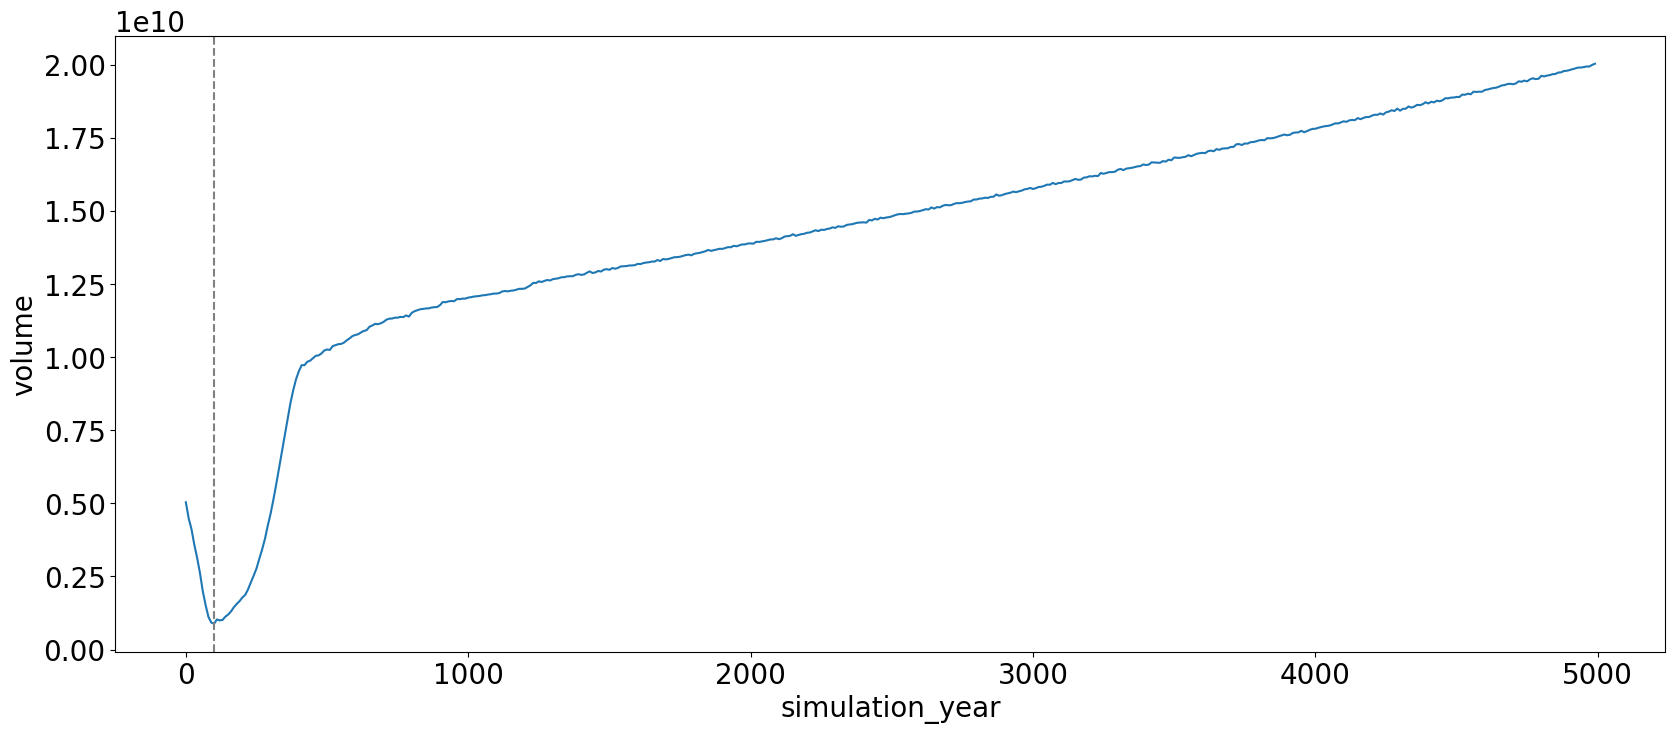

In [112]:
rgi_crazy = 'RGI60-19.02149'
plt.figure(figsize=(20,8))
plt.plot(ds_future_hot.simulation_year, ds_future_hot.sel(rgi_id=rgi_crazy).volume_m3.isel(gcm=0).values.flatten())
#plt.gca().semilogy()
plt.axvline(100, color = 'grey', ls = '--')
plt.ylabel('volume')
plt.xlabel('simulation_year')
print(ds_future_hot.sel(rgi_id=rgi_crazy).volume_m3.isel(gcm=0).gcm.values)
print(ds_future_hot.sel(rgi_id=rgi_crazy).volume_m3.isel(gcm=0).ssp.values)
print(ds_future_hot.sel(rgi_id=rgi_crazy).volume_m3.isel(gcm=0).period.values)
print(ds_future_hot.sel(rgi_id=rgi_crazy).volume_m3.isel(gcm=0).rgi_id.values)

gfdl-esm4
['ssp585']
['2081-2100']
RGI60-19.02147


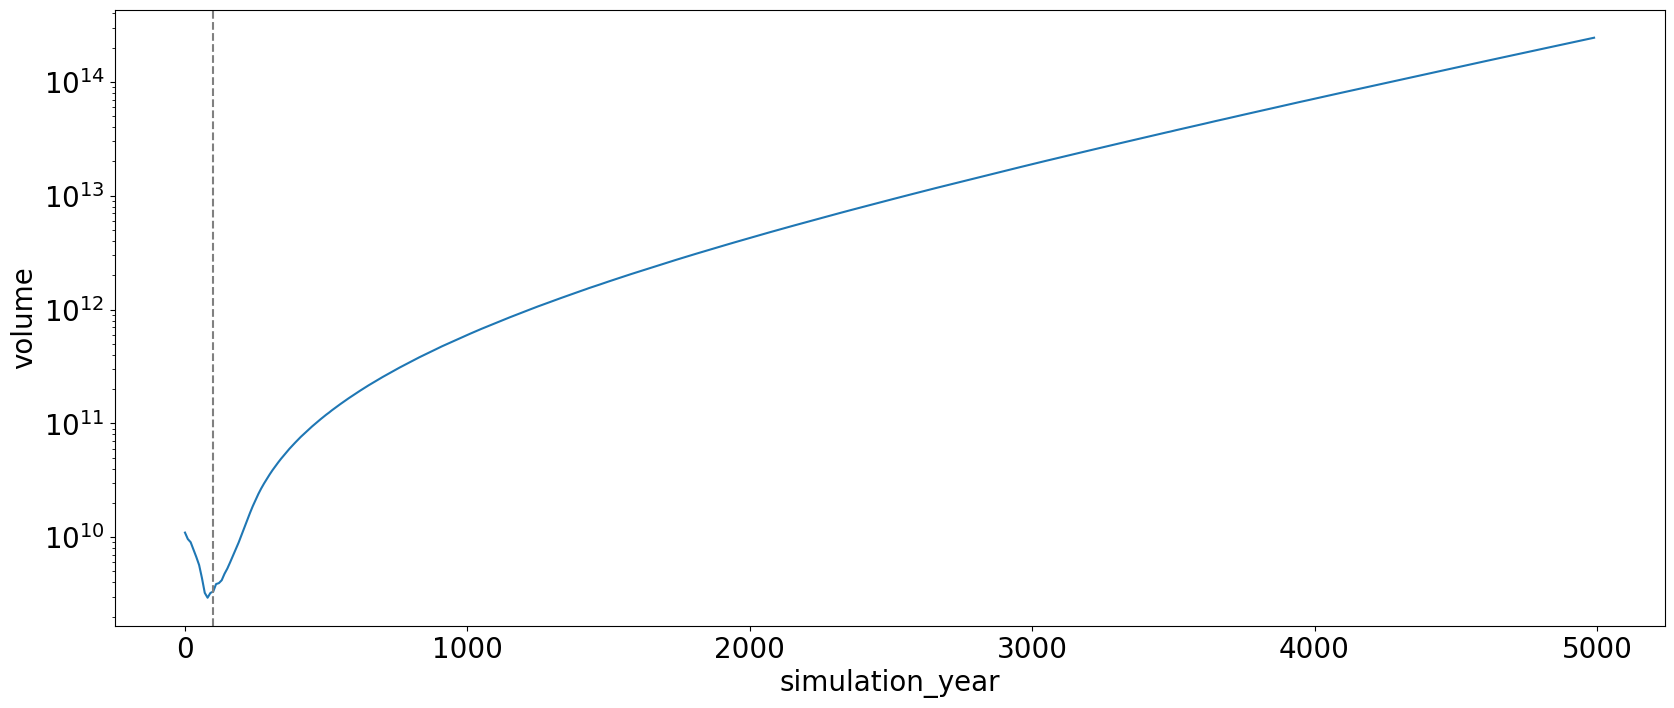

In [106]:
plt.figure(figsize=(20,8))
plt.plot(ds_future_hot.simulation_year, ds_future_hot.sel(rgi_id='RGI60-19.02147').volume_m3.isel(gcm=0).values.flatten())
plt.gca().semilogy()
plt.axvline(100, color = 'grey', ls = '--')
plt.ylabel('volume')
plt.xlabel('simulation_year')
print(ds_future_hot.sel(rgi_id='RGI60-19.02147').volume_m3.isel(gcm=0).gcm.values)
print(ds_future_hot.sel(rgi_id='RGI60-19.02147').volume_m3.isel(gcm=0).ssp.values)
print(ds_future_hot.sel(rgi_id='RGI60-19.02147').volume_m3.isel(gcm=0).period.values)
print(ds_future_hot.sel(rgi_id='RGI60-19.02147').volume_m3.isel(gcm=0).rgi_id.values)

In [85]:
ds_future_hot.sel(rgi_id='RGI60-19.02147').volume_m3.isel(gcm=0)

<xarray.DataArray 'volume_m3' (ssp: 1, period: 1, rgi_reg: 1,
                               simulation_year: 500)>
array([[[[1.0191768e+10, 1.0833780e+10, 1.1745098e+10, 1.2782735e+10,
          1.3674785e+10, 1.4557882e+10, 1.5879006e+10, 1.7204658e+10,
          1.9023092e+10, 2.1002723e+10, 2.3133071e+10, 2.5320104e+10,
          2.7617321e+10, 2.9869091e+10, 3.2154845e+10, 3.4384896e+10,
          3.6510212e+10, 3.8690775e+10, 4.0514691e+10, 4.2361184e+10,
          4.3967803e+10, 4.5422871e+10, 4.6364266e+10, 4.7315698e+10,
          4.8333947e+10, 4.9711755e+10, 5.1199054e+10, 5.2476555e+10,
          5.3435924e+10, 5.4370484e+10, 5.5258649e+10, 5.6175194e+10,
          5.6969458e+10, 5.7774903e+10, 5.8624434e+10, 5.9539374e+10,
          6.0236644e+10, 6.0992229e+10, 6.1800350e+10, 6.2613180e+10,
          6.3160492e+10, 6.3784575e+10, 6.4567304e+10, 6.5284751e+10,
          6.6004697e+10, 6.6577039e+10, 6.7250332e+10, 6.7885728e+10,
          6.8513055e+10, 6.8967596e+10, 6.9667283e+10, 7.0278038e+10,
          7.0810288e+10, 7.1115153e+10, 7.1790846e+10, 7.2400978e+10,
          7.2805384e+10, 7.3399501e+10, 7.4194076e+10, 7.4620289e+10,
          7.5262960e+10, 7.5781112e+10, 7.6203606e+10, 7.6461195e+10,
          7.7106717e+10, 7.7546775e+10, 7.7884752e+10, 7.8183629e+10,
          7.8610784e+10, 7.8775140e+10, 7.9256650e+10, 7.9738241e+10,
          8.0110535e+10, 8.0563855e+10, 8.0688546e+10, 8.1133412e+10,
          8.1277690e+10, 8.1678836e+10, 8.1990164e+10, 8.2249933e+10,
...
          9.4585430e+10, 9.4760821e+10, 9.4642758e+10, 9.4715290e+10,
          9.4683292e+10, 9.4693761e+10, 9.4704927e+10, 9.4757364e+10,
          9.4700110e+10, 9.4630109e+10, 9.4742757e+10, 9.4564426e+10,
          9.4767710e+10, 9.4780244e+10, 9.4698177e+10, 9.4800626e+10,
          9.4738784e+10, 9.4765867e+10, 9.4781678e+10, 9.4687617e+10,
          9.4776099e+10, 9.4857003e+10, 9.4609785e+10, 9.4726898e+10,
          9.4789157e+10, 9.4669840e+10, 9.4835114e+10, 9.4695342e+10,
          9.4858191e+10, 9.4887461e+10, 9.4770930e+10, 9.4795121e+10,
          9.4752915e+10, 9.4839497e+10, 9.4756569e+10, 9.4671143e+10,
          9.4744863e+10, 9.4800740e+10, 9.4733214e+10, 9.4803870e+10,
          9.4739743e+10, 9.4784299e+10, 9.4715863e+10, 9.4725145e+10,
          9.4792008e+10, 9.4924366e+10, 9.4656487e+10, 9.4769553e+10,
          9.4816240e+10, 9.4914396e+10, 9.4910988e+10, 9.4914552e+10,
          9.5113560e+10, 9.5140332e+10, 9.5054889e+10, 9.5164359e+10,
          9.5038849e+10, 9.5079858e+10, 9.5151358e+10, 9.5070478e+10,
          9.5242887e+10, 9.5202247e+10, 9.5111143e+10, 9.5033795e+10,
          9.5116624e+10, 9.5214150e+10, 9.5064433e+10, 9.5260262e+10,
          9.5143969e+10, 9.5123915e+10, 9.5107547e+10, 9.5206572e+10,
          9.5106728e+10, 9.5000232e+10, 9.5243485e+10, 9.5249342e+10]]]],
      dtype=float32)
Coordinates:
  * simulation_year  (simulation_year) int16 0 10 20 30 ... 4960 4970 4980 4990
    rgi_id           <U14 'RGI60-19.02147'
  * ssp              (ssp) object 'ssp126'
  * period           (period) object '2081-2100'
  * rgi_reg          (rgi_reg) object '19'
    gcm              <U9 'gfdl-esm4'
Attributes:
    units:      m3
    long_name:  Glacier volume at timestamp

### Check if the new `no-runaway` files work right:

In [135]:
# https://cluster.klima.uni-bremen.de/~drounce/per_glacier-filled-norunaway/19/Rounce_rgi19_glaciers_2081-2100_ukesm1-0-ll_ssp585_Batch-27001-28000.nc

In [137]:
ds_no_runaway

<xarray.Dataset>
Dimensions:          (simulation_year: 5001, rgi_id: 2752)
Coordinates:
  * simulation_year  (simulation_year) int16 0 1 2 3 4 ... 4997 4998 4999 5000
  * rgi_id           (rgi_id) object 'RGI60-19.00001' ... 'RGI60-19.02752'
Data variables:
    volume_m3        (simulation_year, rgi_id) float32 dask.array<chunksize=(5001, 1000), meta=np.ndarray>
    area_m2          (simulation_year, rgi_id) float32 dask.array<chunksize=(5001, 1000), meta=np.ndarray>
Attributes:
    contributor:        Rounce
    contributor_email:  drounce@cmu.edu
    creation_date:      25/06/2022
    rgi-region:         rgi19
    aggregation-level:  glaciers
    period:             ssp585_2081-2100
    gcm:                gfdl-esm4
    ssp:                ssp585
    information:        PyGEM for mass balance and calibration with OGGM for ...
    stop_criterion:     Simulations were stopped if volume was 0 for 20 years...

In [205]:
def func_plot_crazy(ssp = 'ssp585', period='2081-2100', ylim1=3e10, rgi_crazy = 'RGI60-19.02147', rgi_reg = '19'):
    pathi = f'/home/www/drounce/per_glacier-filled-norunaway/{rgi_reg}/Rounce_rgi{rgi_reg}_glaciers_{period}_gfdl-esm4_{ssp}*.nc'
    ds_no_runaway = xr.open_mfdataset(pathi)
    pathi_old = f'/home/www/drounce/per_glacier/19/Rounce_rgi{rgi_reg}_glaciers_{period}_gfdl-esm4_{ssp}*.nc'
    ds_old_wrunaway = xr.open_mfdataset(pathi_old)
    plt.plot(ds_old_wrunaway.simulation_year, ds_old_wrunaway.sel(rgi_id=rgi_crazy).volume_m3.load(), label='old version: with runaway')
    #plt.gca().semilogy()
    plt.axvline(100, color = 'grey', ls = '--')
    plt.ylabel('volume')
    plt.xlabel('simulation_year')
    plt.plot(ds_no_runaway.simulation_year, ds_no_runaway.sel(rgi_id=rgi_crazy).volume_m3.load(), label='new version: cut runaway')
    plt.title(f'{rgi_crazy}\n{ds_no_runaway.gcm}, {ds_no_runaway.period}')
    #plt.xticks([0,100,500,1000,2000,3000,4000,5000], fontsize=16)
    plt.xlim([0,300])
    plt.grid()
    plt.ylim([0.2,ylim1])
    plt.legend()


KeyError: "not all values found in index 'rgi_id'. Try setting the `method` keyword argument (example: method='nearest')."

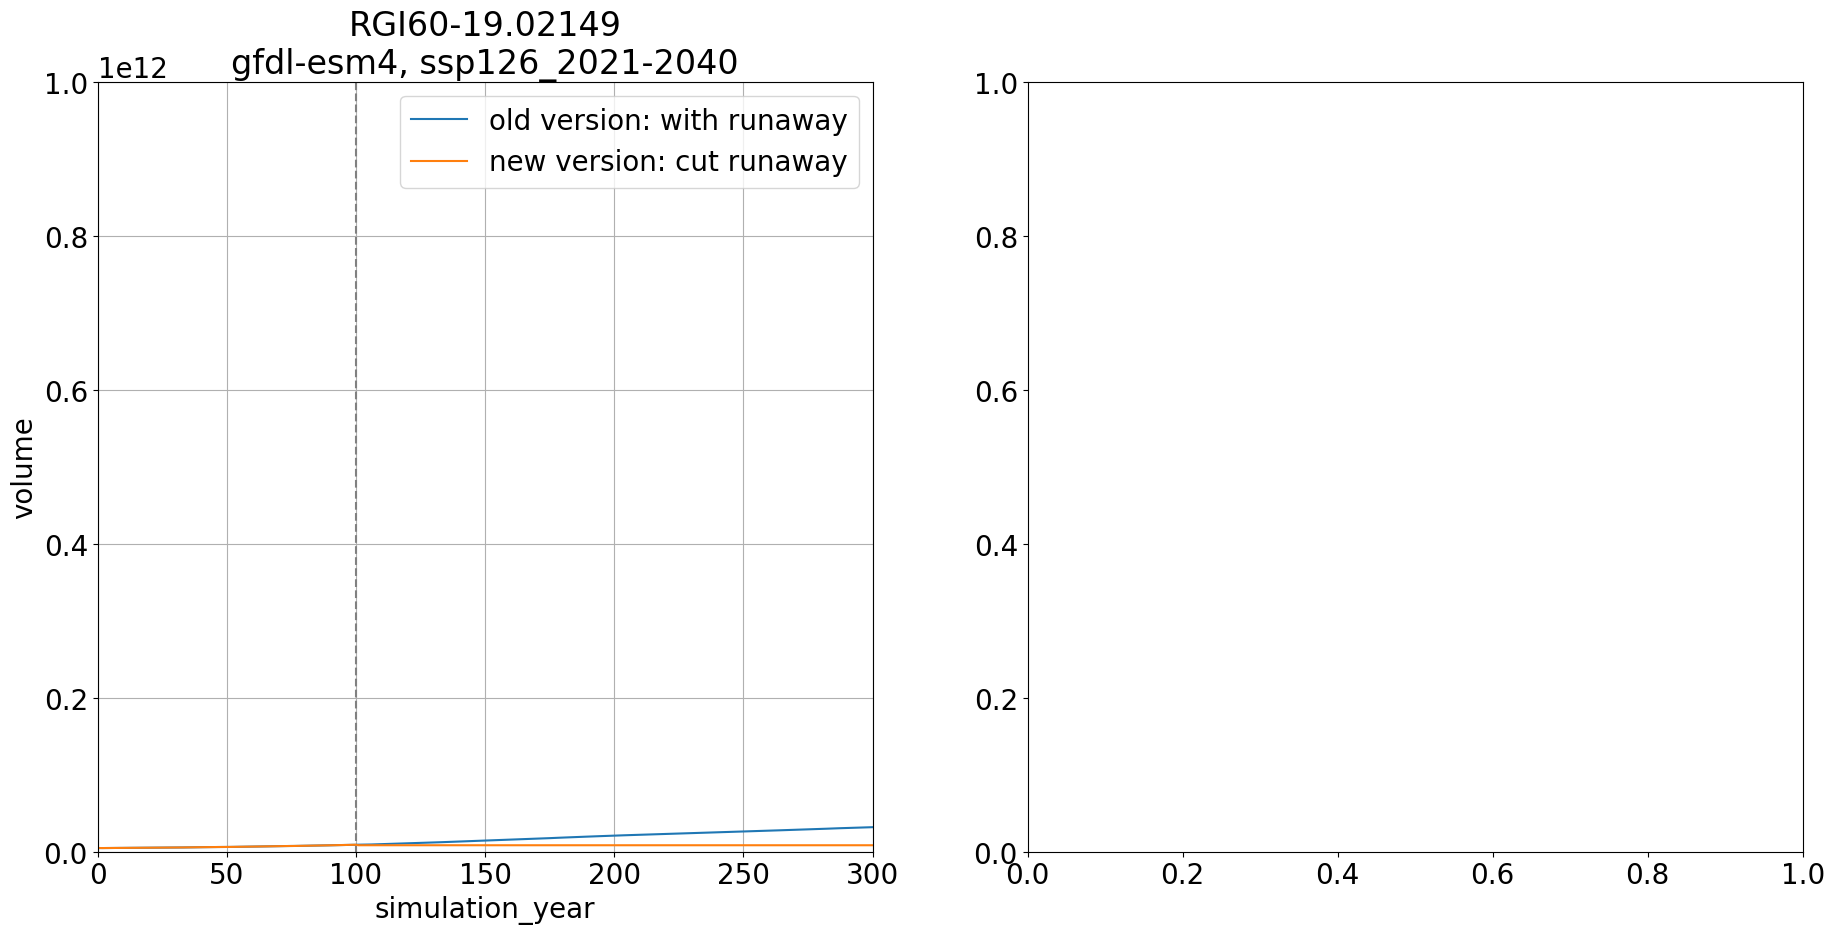

In [195]:
plt.figure(figsize=(34,10))
plt.subplot(131)
func_plot_crazy(ssp = 'ssp126', period='2021-2040', ylim1=1e12, rgi_crazy = 'RGI60-19.02149')
plt.subplot(132)
func_plot_crazy(ssp = 'ssp370', period='2021-2040', ylim1=1e12, rgi_crazy = 'RGI60-19.02149')

#func_plot_crazy(ssp = 'ssp370', period='2021-2040', ylim1=1e12)

plt.subplot(133)
func_plot_crazy(ssp = 'ssp585', period='2021-2040', ylim1=1e12, rgi_crazy = 'RGI60-19.02149')





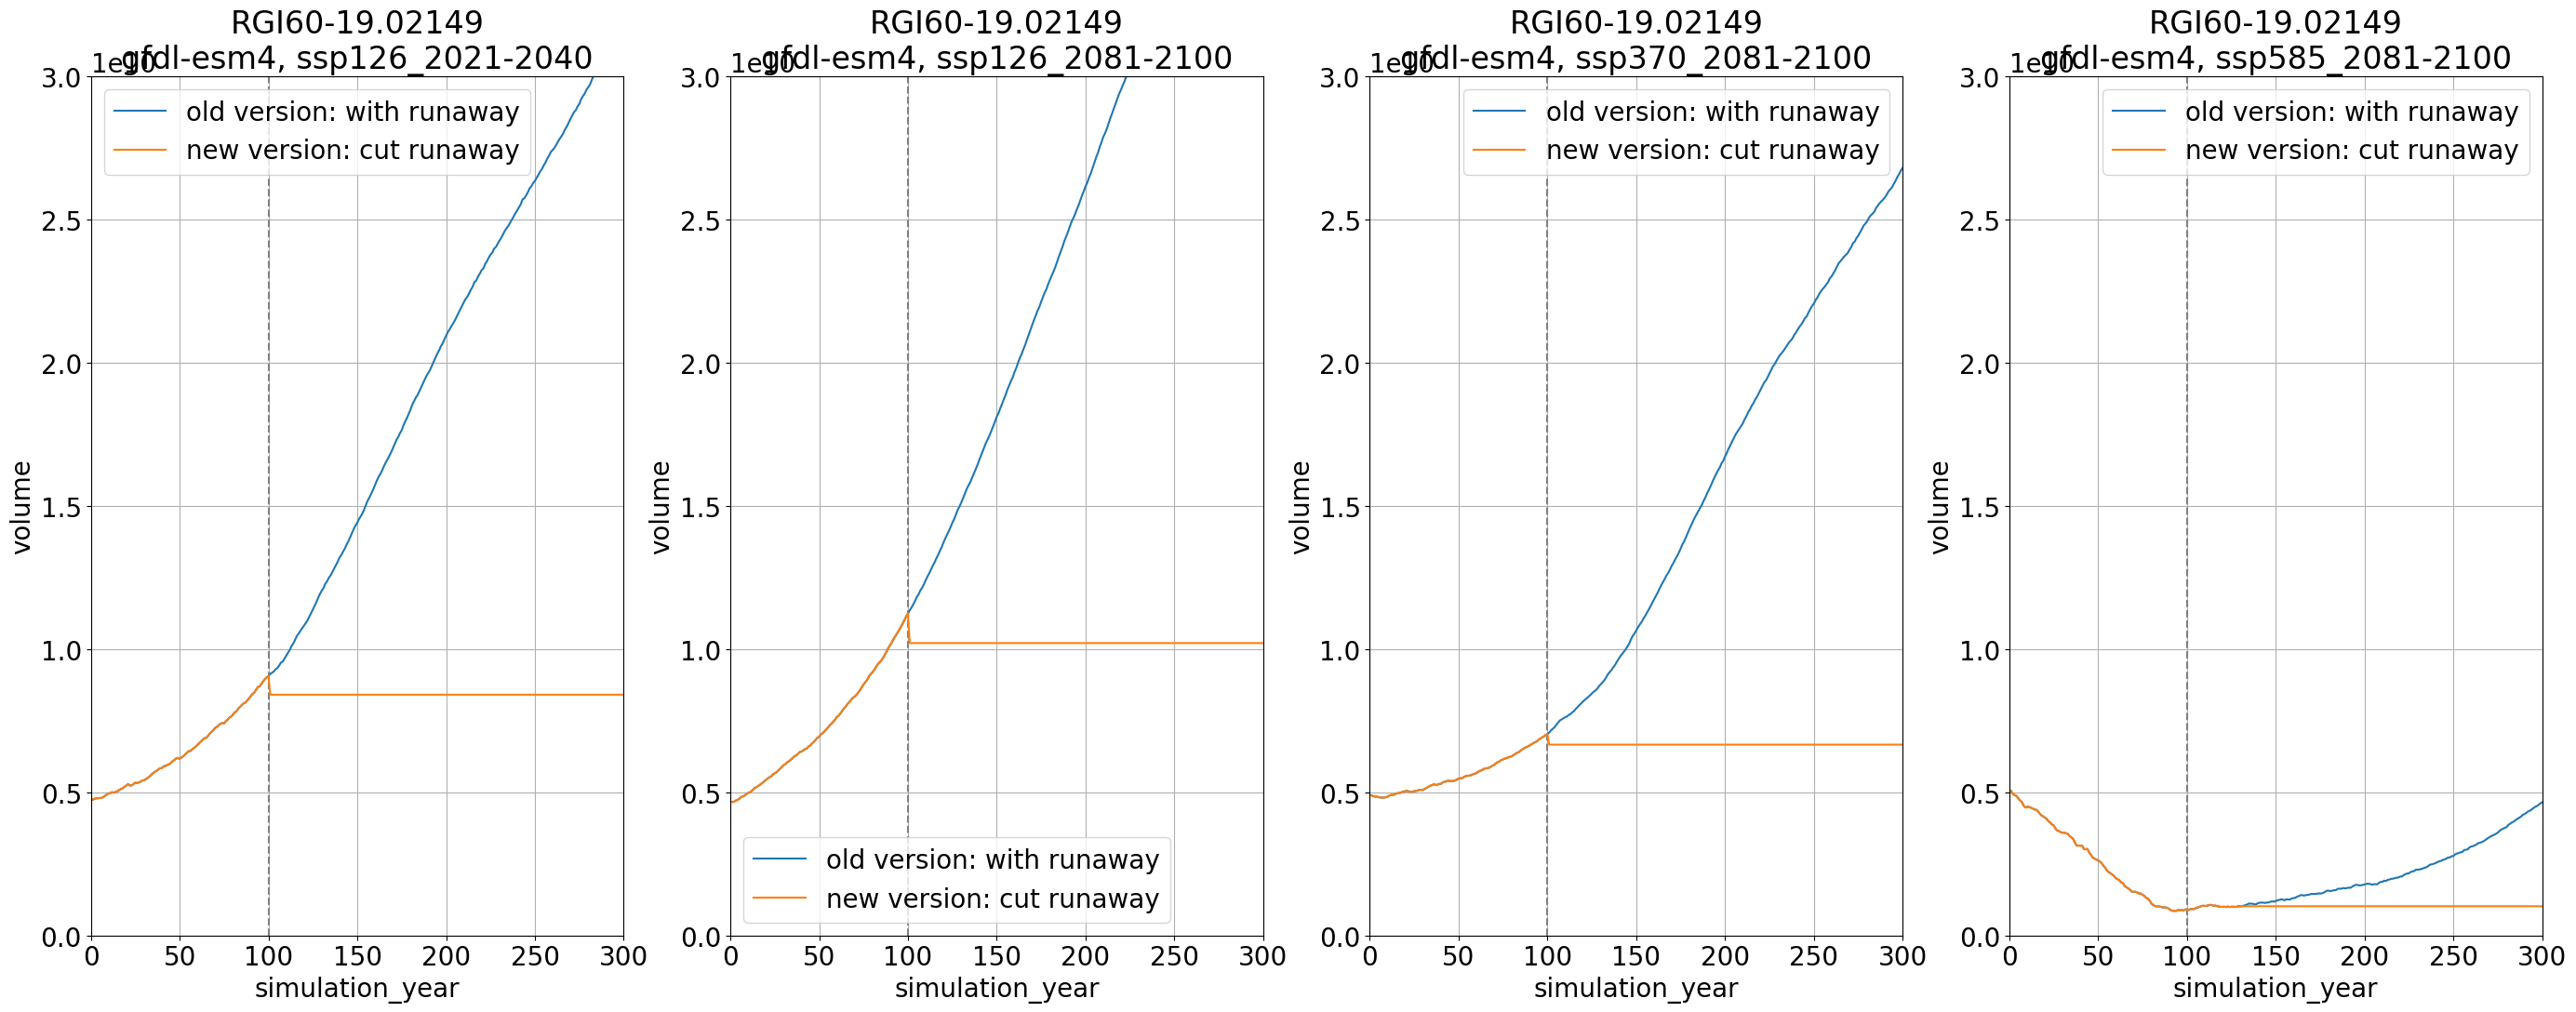

In [203]:
plt.figure(figsize=(34,12))

plt.subplot(141)
func_plot_crazy(ssp = 'ssp126', period='2021-2040', rgi_crazy = 'RGI60-19.02149')
#func_plot_crazy(ssp = 'hist', period='1995-2014')
plt.subplot(142)
func_plot_crazy(ssp = 'ssp126', period='2081-2100', rgi_crazy = 'RGI60-19.02149')
plt.subplot(143)
func_plot_crazy(ssp = 'ssp370', period='2081-2100', rgi_crazy = 'RGI60-19.02149')

plt.subplot(144)
func_plot_crazy(ssp = 'ssp585', period='2081-2100', rgi_crazy = 'RGI60-19.02149')





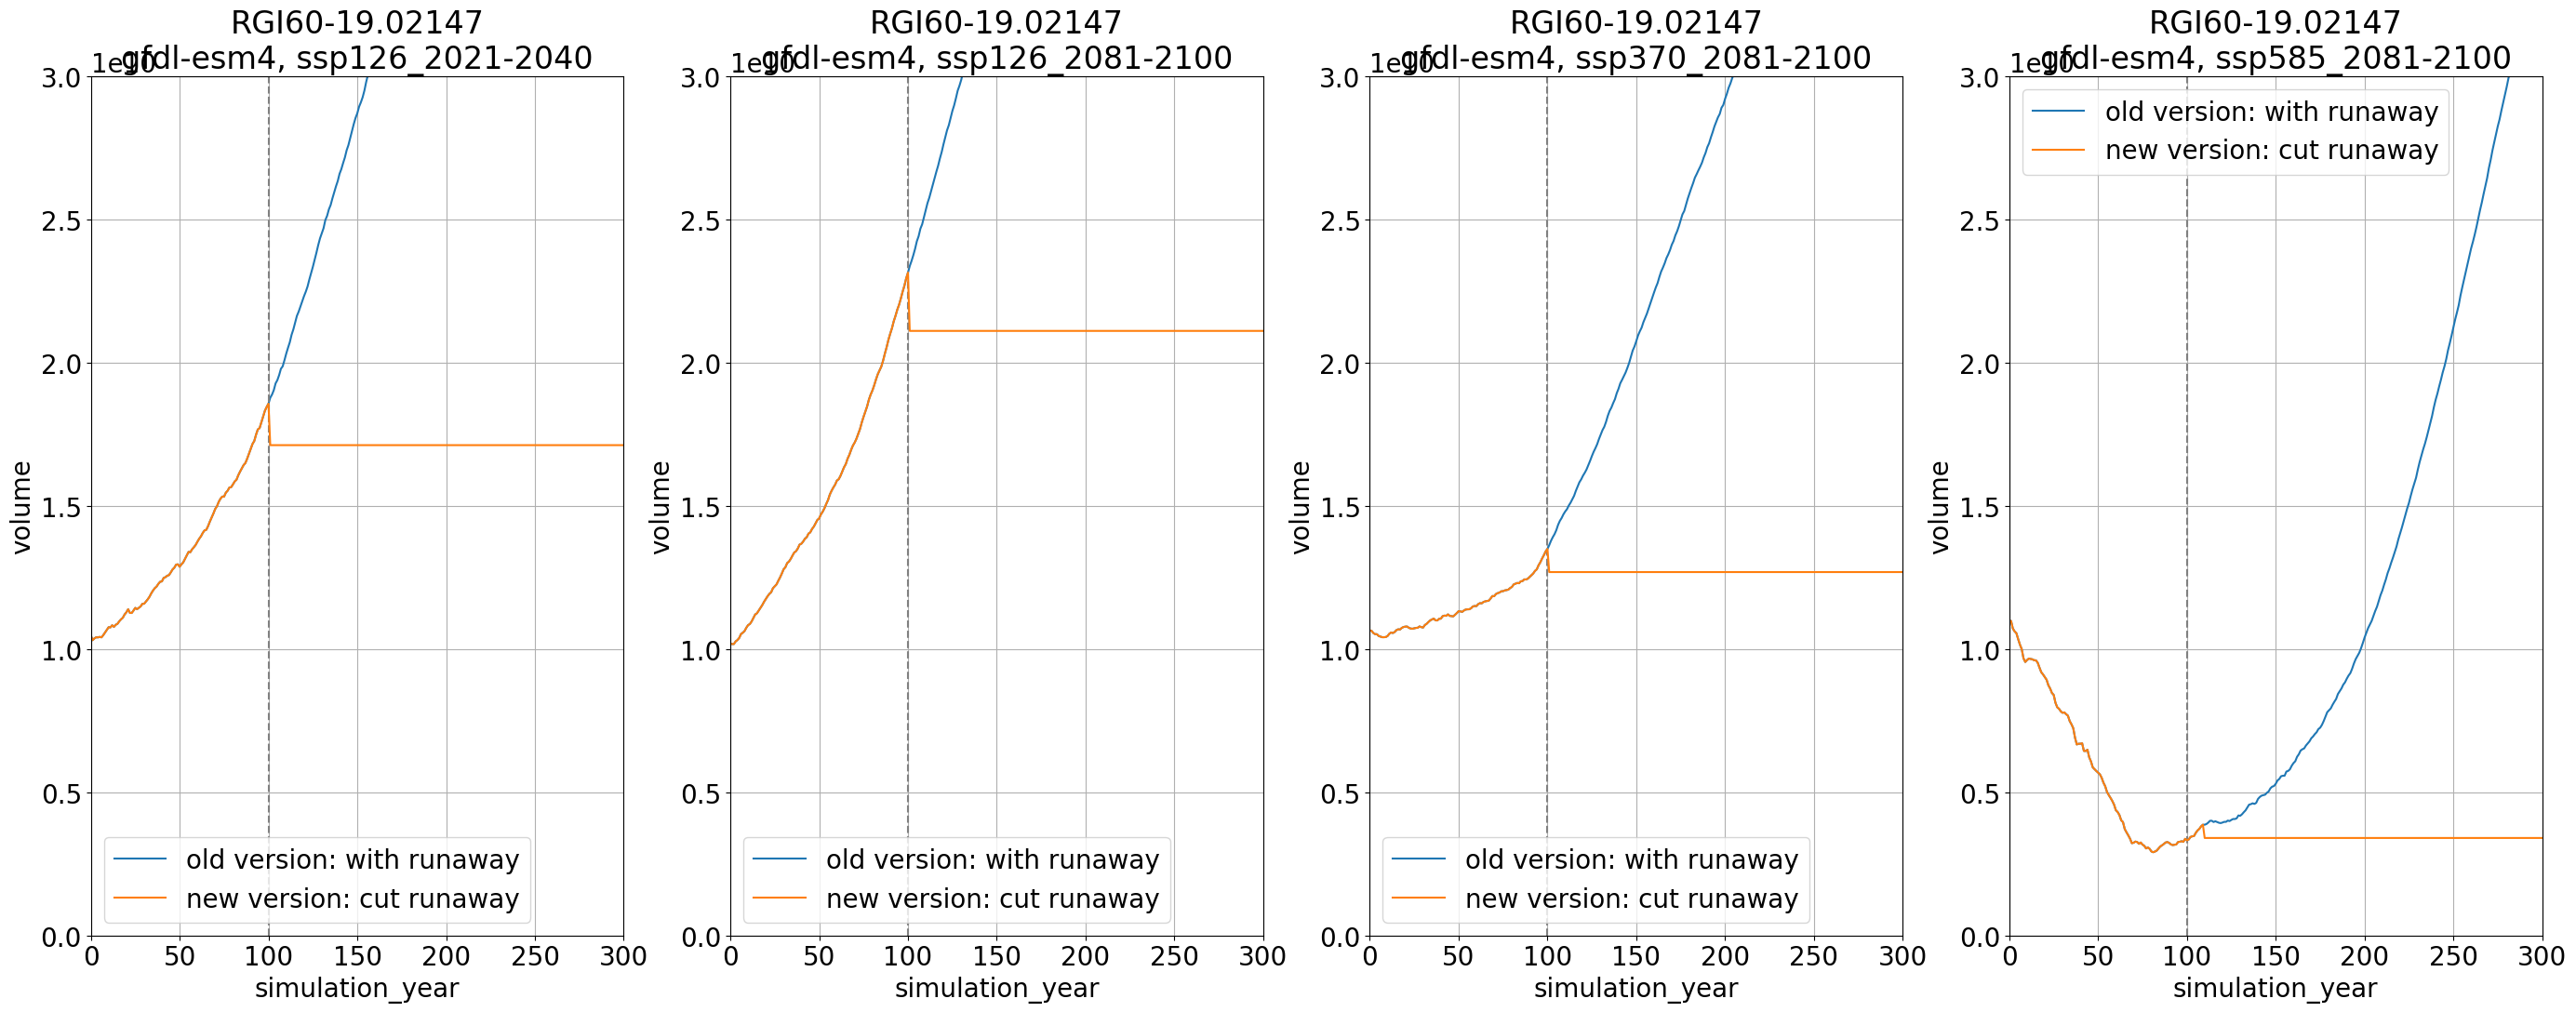

In [204]:
plt.figure(figsize=(34,12))

plt.subplot(141)
func_plot_crazy(ssp = 'ssp126', period='2021-2040')
#func_plot_crazy(ssp = 'hist', period='1995-2014')
plt.subplot(142)
func_plot_crazy(ssp = 'ssp126', period='2081-2100')
plt.subplot(143)
func_plot_crazy(ssp = 'ssp370', period='2081-2100')

plt.subplot(144)
func_plot_crazy(ssp = 'ssp585', period='2081-2100')





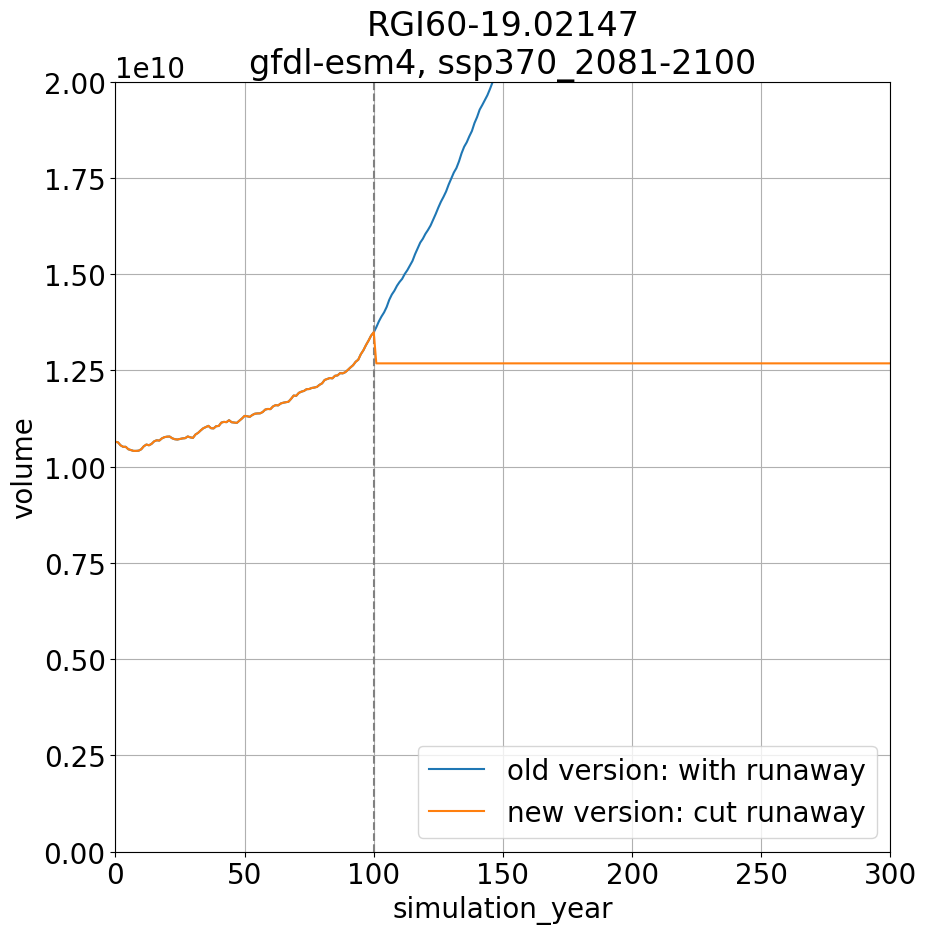